In [1]:
import pandas as pd
import numpy as np
import joblib
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/0930.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")

load_path = "/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/"

# /Users/bg.lim/Downloads/TAMU_Agri/New_CGM
path = "/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/df_alerts_raw.csv"
df_alerts_raw = pd.read_csv(path, low_memory=False)

# 1) 알림 메타정보
X_alerts = pd.read_csv(load_path + "1001alerts_with_X.csvX_alerts.csv")

# 2) SHAP 행렬 (raw positive-only)
shap_pos_clipped = np.load(load_path + "1001alerts_with_X.csv1001shap_pos_clipped.npy")

# 3) SHAP 행렬 (scaled)
X_scaled = np.load(load_path + "1001alerts_with_X.csv1001X_scaled.npy")

# 4) Feature 이름
FEATURES = joblib.load(load_path + "1001alerts_with_X.csvFEATURES.pkl")

# 확인
print("불러오기 완료!")
print("X_alerts shape:", X_alerts.shape)           
print("shap_pos_clipped shape:", shap_pos_clipped.shape)  
print("X_scaled shape:", X_scaled.shape)           
print("FEATURES 개수:", len(FEATURES))
print("예시 FEATURES:", FEATURES[:10])


불러오기 완료!
X_alerts shape: (634, 6)
shap_pos_clipped shape: (634, 79)
X_scaled shape: (634, 79)
FEATURES 개수: 79
예시 FEATURES: ['15m_G_Diff_5', '15m_G_Diff_6', '15m_G_Diff_7', '15m_G_Diff_8', '15m_G_Diff_9', '15m_G_Diff_10', 'Z_Previous_5', 'Z_Previous_6', 'Z_Previous_7', 'Z_Previous_8']


/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_82023/1178273880.py:7: DtypeWarning: Columns (95,96) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="utf-8")


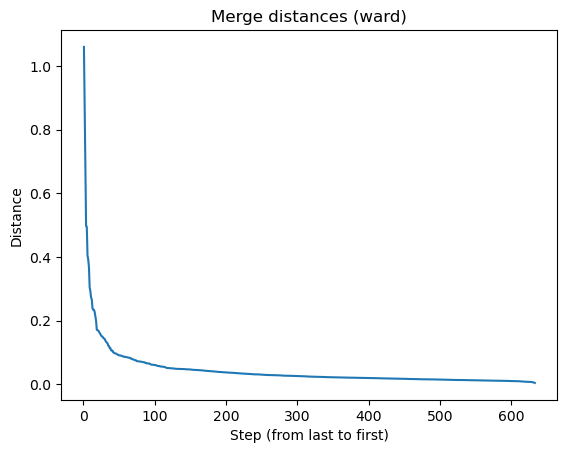

Natural cut point suggests ~3 clusters
{1: 63, 2: 174, 3: 397}


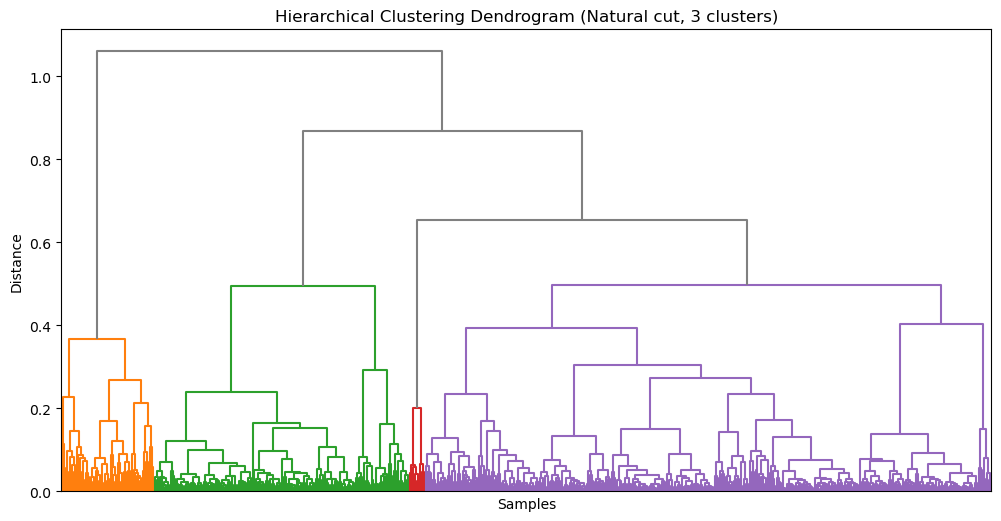

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# === 1) SHAP scaled 행렬 사용 ===
X_raw = shap_pos_clipped   # or X_scaled (둘 중 하나 선택)
# X_scaled: 이미 StandardScaler 적용됨

# === 2) linkage 계산 ===
Z = linkage(X_raw, method="ward")

# === 3) 병합 거리 확인 ===
distances = Z[:, 2]  # 세 번째 열이 병합 거리
plt.plot(range(1, len(distances)+1), distances[::-1])
plt.title("Merge distances (ward)")
plt.xlabel("Step (from last to first)")
plt.ylabel("Distance")
plt.show()

# === 4) 자연스러운 컷 포인트 찾기 ===
diffs = np.diff(distances)
cut_idx = np.argmax(diffs)
n_clusters = len(distances) - cut_idx
print(f"Natural cut point suggests ~{n_clusters} clusters")

# === 5) 해당 컷 포인트로 클러스터링 ===
clusters = fcluster(Z, t=distances[cut_idx], criterion="distance")

# === 6) 결과 확인 ===
unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))

# === 7) 덴도그램 시각화 ===
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    color_threshold=distances[cut_idx],
    above_threshold_color="gray",
    no_labels=True
)
plt.title(f"Hierarchical Clustering Dendrogram (Natural cut, {n_clusters} clusters)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

# === 8) 클러스터 라벨을 X_alerts 메타데이터에 붙이기 ===
X_with_cluster = X_alerts.copy()
X_with_cluster["Cluster"] = clusters

In [5]:
import numpy as np
import pandas as pd

# === 클러스터별 평균 SHAP 절대값 계산 ===
cluster_shap_mean = {}
for clust in np.unique(X_with_cluster["Cluster"]):
    idx = X_with_cluster["Cluster"] == clust
    cluster_shap_mean[clust] = np.abs(shap_pos_clipped[idx]).mean(axis=0)

# === 클러스터별 Top 5 feature 뽑기 ===
top_feats = {}
for clust, shap_vals in cluster_shap_mean.items():
    top_idx = np.argsort(shap_vals)[::-1][:5]   # 상위 5개 인덱스
    top_feats[clust] = [FEATURES[i] for i in top_idx]

print("Top5 feature by cluster:")
for c, feats in top_feats.items():
    print(f"Cluster {c}: {feats}")

Top5 feature by cluster:
Cluster 1: ['hungry', 'mean_intensity_1h', 'hungry_within', 'Time_24h', 'How_tired']
Cluster 2: ['Z_Previous_4', 'Time_24h', 'mean_intensity_1h', 'G_minus_T_pre_1.5h', 'How_anxious_within']
Cluster 3: ['mean_intensity_1h', 'Time_24h', 'hungry', 'hungry_within', 'TimeInBed']


In [7]:
# ts를 datetime으로 변환 후 시각을 float으로
df_alerts_raw["ts"] = pd.to_datetime(df_alerts_raw["ts"], errors="coerce")
df_alerts_raw["Time_24h"] = df_alerts_raw["ts"].dt.hour + df_alerts_raw["ts"].dt.minute / 60


In [21]:
# CSV 파일 불러오기
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/merged_df1014.csv'
# 파일 로드 (인코딩 에러 방지)
merged_df = pd.read_csv(file_path, encoding="utf-8")

merged_df

,StudyID,ts,date,y_true_at_alert,y_prob_at_alert,success,Cluster,Success_2h,Timestamp,Glucose,...,How_angry_person_mean,How_angry_within,How_sad_person_mean,How_sad_within,How_energetic_person_mean,How_energetic_within,How_tired_person_mean,How_tired_within,How_lonely_person_mean,How_lonely_within
0,1,2022-10-13 18:42:00,2022-10-13,1,0.714333,1,2,1,2022-10-13 18:42:00,114,...,0.0,0.0,0.000000,0.000000,0.721945,-0.055278,0.145054,0.188279,0.0,0.0
1,1,2022-10-13 20:57:00,2022-10-13,0,0.635162,0,2,1,2022-10-13 20:57:00,97,...,0.0,0.0,0.000000,0.000000,0.721945,-0.055278,0.145054,0.188279,0.0,0.0
2,1,2022-10-14 15:57:00,2022-10-14,1,0.731867,1,1,1,2022-10-14 15:57:00,105,...,0.0,0.0,0.000000,0.000000,0.721945,-0.055278,0.145054,-0.145054,0.0,0.0
3,1,2022-10-14 18:57:00,2022-10-14,0,0.622380,0,2,1,2022-10-14 18:57:00,106,...,0.0,0.0,0.000000,0.000000,0.721945,-0.055278,0.145054,0.188279,0.0,0.0
4,1,2022-10-14 20:42:00,2022-10-14,0,0.461395,0,2,0,2022-10-14 20:42:00,105,...,0.0,0.0,0.000000,0.000000,0.721945,-0.055278,0.145054,0.188279,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,89,2023-05-07 20:08:00,2023-05-07,0,0.462291,0,3,0,2023-05-07 20:08:00,90,...,0.0,0.0,0.004877,-0.004877,0.562536,0.104131,0.349971,-0.016638,0.0,0.0
630,89,2023-05-08 15:23:00,2023-05-08,0,0.471260,0,3,1,2023-05-08 15:23:00,79,...,0.0,0.0,0.004877,-0.004877,0.562536,0.104131,0.349971,-0.016638,0.0,0.0
631,89,2023-05-08 17:53:00,2023-05-08,0,0.360599,0,3,1,2023-05-08 17:53:00,131,...,0.0,0.0,0.004877,-0.004877,0.562536,-0.229203,0.349971,0.316695,0.0,0.0
632,89,2023-05-09 15:38:00,2023-05-09,0,0.406461,0,3,0,2023-05-09 15:38:00,89,...,0.0,0.0,0.004877,-0.004877,0.562536,0.104131,0.349971,-0.016638,0.0,0.0


# False Positive in each Cluster

In [11]:
from datetime import timedelta
import pandas as pd
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# ts를 datetime으로 변환 (에러 해결 핵심)
X_with_cluster["ts"] = pd.to_datetime(X_with_cluster["ts"])

success_flags = []

for sid, df_sub in df.groupby("StudyID"):
    df_sub = df_sub.sort_values("Timestamp")
    alerts_sub = X_with_cluster.query("StudyID == @sid").copy()
    
    for ts in alerts_sub["ts"]:
        window_end = ts + timedelta(hours=2)
        has_GE = ((df_sub["Timestamp"] >= ts) &
                  (df_sub["Timestamp"] <= window_end) &
                  (df_sub["GE_1h"] == 1)).any()
        success_flags.append(int(has_GE))

X_with_cluster["Success_2h"] = success_flags


In [13]:
X_with_cluster

,StudyID,ts,date,y_true_at_alert,y_prob_at_alert,success,Cluster,Success_2h
0,1,2022-10-13 18:42:00,2022-10-13,1,0.714333,1,2,1
1,1,2022-10-13 20:57:00,2022-10-13,0,0.635162,0,2,1
2,1,2022-10-14 15:57:00,2022-10-14,1,0.731867,1,1,1
3,1,2022-10-14 18:57:00,2022-10-14,0,0.622380,0,2,1
4,1,2022-10-14 20:42:00,2022-10-14,0,0.461395,0,2,0
...,...,...,...,...,...,...,...,...
629,89,2023-05-07 20:08:00,2023-05-07,0,0.462291,0,3,0
630,89,2023-05-08 15:23:00,2023-05-08,0,0.471260,0,3,1
631,89,2023-05-08 17:53:00,2023-05-08,0,0.360599,0,3,1
632,89,2023-05-09 15:38:00,2023-05-09,0,0.406461,0,3,0


In [15]:
import pandas as pd

# 클러스터별 success(=TP)와 실패(=FP) 카운트
summary = (
    X_with_cluster.groupby("Cluster")["Success_2h"]
    .agg(["mean", "count"])
    .rename(columns={"mean": "Success_rate", "count": "n"})
    .reset_index()
)

# False Positive rate
summary["FP_rate"] = 1 - summary["Success_rate"]

# 전체 성공률 (가중평균)
total_n = summary["n"].sum()
total_success = (summary["Success_rate"] * summary["n"]).sum() / total_n

# summary 마지막 행에 전체 성공률 추가
summary.loc[len(summary)] = ["Total", total_n, total_success, 1 - total_success]

# 보기 좋게 정리
summary = summary[["Cluster", "n", "Success_rate", "FP_rate"]]
print(summary)


  Cluster           n  Success_rate   FP_rate
0       1   63.000000      0.555556  0.444444
1       2  174.000000      0.402299  0.597701
2       3  397.000000      0.309824  0.690176
3   Total    0.359621    634.000000  0.640379


# Confirm by sample from each Cluster 

In [102]:
merged_df.to_csv("merged_df1014.csv", index=False)

In [31]:
merged_df

,StudyID,ts,date,y_true_at_alert,y_prob_at_alert,success,Cluster,Success_2h,Timestamp,Glucose,...,How_angry_person_mean,How_angry_within,How_sad_person_mean,How_sad_within,How_energetic_person_mean,How_energetic_within,How_tired_person_mean,How_tired_within,How_lonely_person_mean,How_lonely_within
0,1,2022-10-13 18:42:00,2022-10-13,1,0.714333,1,2,1,2022-10-13 18:42:00,114,...,0.0,0.0,0.000000,0.000000,0.721945,-0.055278,0.145054,0.188279,0.0,0.0
1,1,2022-10-13 20:57:00,2022-10-13,0,0.635162,0,2,1,2022-10-13 20:57:00,97,...,0.0,0.0,0.000000,0.000000,0.721945,-0.055278,0.145054,0.188279,0.0,0.0
2,1,2022-10-14 15:57:00,2022-10-14,1,0.731867,1,1,1,2022-10-14 15:57:00,105,...,0.0,0.0,0.000000,0.000000,0.721945,-0.055278,0.145054,-0.145054,0.0,0.0
3,1,2022-10-14 18:57:00,2022-10-14,0,0.622380,0,2,1,2022-10-14 18:57:00,106,...,0.0,0.0,0.000000,0.000000,0.721945,-0.055278,0.145054,0.188279,0.0,0.0
4,1,2022-10-14 20:42:00,2022-10-14,0,0.461395,0,2,0,2022-10-14 20:42:00,105,...,0.0,0.0,0.000000,0.000000,0.721945,-0.055278,0.145054,0.188279,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,89,2023-05-07 20:08:00,2023-05-07,0,0.462291,0,3,0,2023-05-07 20:08:00,90,...,0.0,0.0,0.004877,-0.004877,0.562536,0.104131,0.349971,-0.016638,0.0,0.0
630,89,2023-05-08 15:23:00,2023-05-08,0,0.471260,0,3,1,2023-05-08 15:23:00,79,...,0.0,0.0,0.004877,-0.004877,0.562536,0.104131,0.349971,-0.016638,0.0,0.0
631,89,2023-05-08 17:53:00,2023-05-08,0,0.360599,0,3,1,2023-05-08 17:53:00,131,...,0.0,0.0,0.004877,-0.004877,0.562536,-0.229203,0.349971,0.316695,0.0,0.0
632,89,2023-05-09 15:38:00,2023-05-09,0,0.406461,0,3,0,2023-05-09 15:38:00,89,...,0.0,0.0,0.004877,-0.004877,0.562536,0.104131,0.349971,-0.016638,0.0,0.0


## Cluster 1

In [25]:
key_vars = [
    "hungry", 
    "hungry_within", 
    "Time_24h",         
    "Z_Previous_4", 
    "mean_intensity_1h",
    "How_tired", 
    "How_anxious_within"
]
import pandas as pd

cluster1 = merged_df.query("Cluster == 1")

summary_cluster1 = (
    cluster1[key_vars]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .T[["mean", "25%", "50%", "75%"]]
    .rename(columns={"mean": "Mean", "25%": "Q25", "50%": "Median", "75%": "Q75"})
)


print("=== Cluster 1 Summary (Raw Value) ===")
print(summary_cluster1.round(3))


=== Cluster 1 Summary (Raw Value) ===
                      Mean     Q25  Median     Q75
hungry_within        0.717   0.632   0.741   0.848
Time_24h            15.419  12.092  16.567  18.125
Z_Previous_4        -0.179  -0.752  -0.367   0.283
mean_intensity_1h    0.299   0.200   0.283   0.392
How_tired            0.212   0.000   0.333   0.333
How_anxious_within   0.044  -0.112  -0.006   0.202


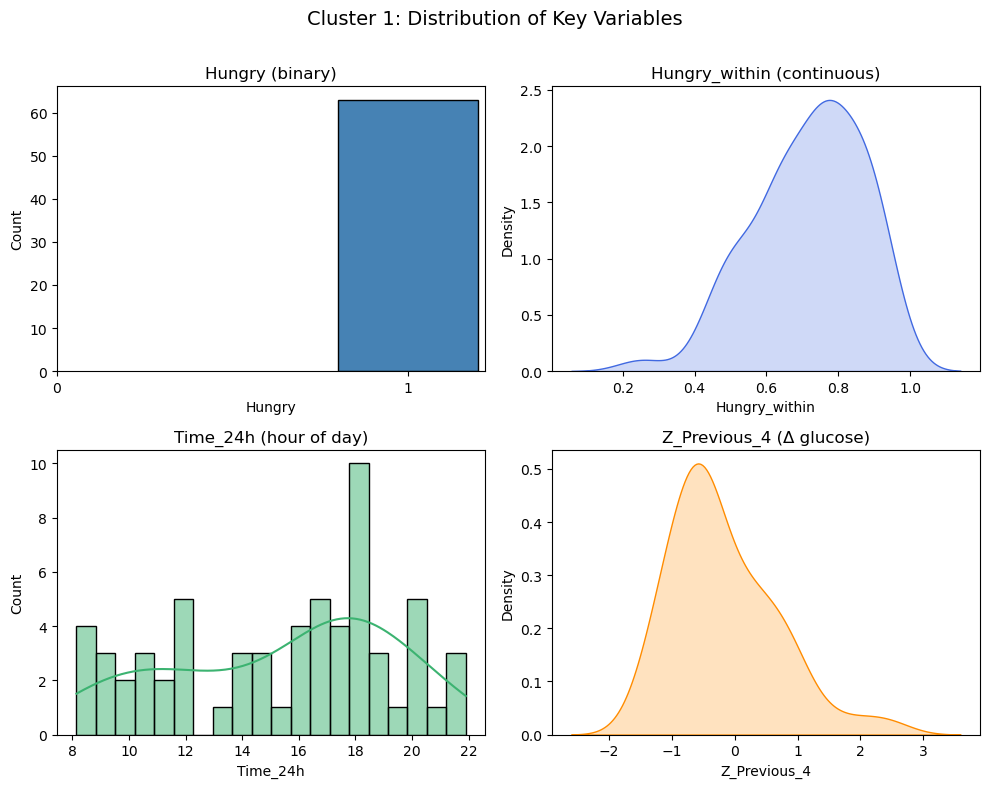

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster1 = merged_df.query("Cluster == 1")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# Hungry (binary) → thinner bars
counts = cluster1["hungry"].value_counts().sort_index()
axes[0].bar(counts.index, counts.values, width=0.4, color="steelblue", edgecolor="black")
axes[0].set_title("Hungry (binary)")
axes[0].set_xticks([0, 1])
axes[0].set_xlabel("Hungry")
axes[0].set_ylabel("Count")

# Hungry_within (continuous)
sns.kdeplot(cluster1["hungry_within"], fill=True, color="royalblue", ax=axes[1])
axes[1].set_title("Hungry_within (continuous)")
axes[1].set_xlabel("Hungry_within")
axes[1].set_ylabel("Density")

# Time_24h (hour of day)
sns.histplot(cluster1["Time_24h"], bins=20, kde=True, ax=axes[2], color="mediumseagreen", edgecolor="black")
axes[2].set_title("Time_24h (hour of day)")
axes[2].set_xlabel("Time_24h")
axes[2].set_ylabel("Count")

# Z_Previous_4 (Δ glucose)
sns.kdeplot(cluster1["Z_Previous_4"], fill=True, color="darkorange", ax=axes[3])
axes[3].set_title("Z_Previous_4 (Δ glucose)")
axes[3].set_xlabel("Z_Previous_4")
axes[3].set_ylabel("Density")

plt.suptitle("Cluster 1: Distribution of Key Variables", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Cluster 2

In [126]:
import pandas as pd

cluster2 = merged_df.query("Cluster == 2")

key_vars_2 = [
    "Z_Previous_4",
    "Time_24h",
    "mean_intensity_1h",
    "G_minus_T_pre_1.5h",
    "How_anxious_within"
]

summary_cluster2 = (
    cluster2[key_vars_2]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .T[["mean", "25%", "50%", "75%"]]
    .rename(columns={"mean": "Mean", "25%": "Q25", "50%": "Median", "75%": "Q75"})
)

print("=== Cluster 2 Summary (Raw Value) ===")
print(summary_cluster2.round(3))


=== Cluster 2 Summary (Raw Value) ===
                      Mean     Q25  Median     Q75
Z_Previous_4         1.978   1.356   1.801   2.367
Time_24h            18.477  17.071  19.067  20.762
mean_intensity_1h    0.243   0.083   0.183   0.317
G_minus_T_pre_1.5h  -7.365 -18.085  -8.207   4.381
How_anxious_within   0.003  -0.096  -0.014   0.093


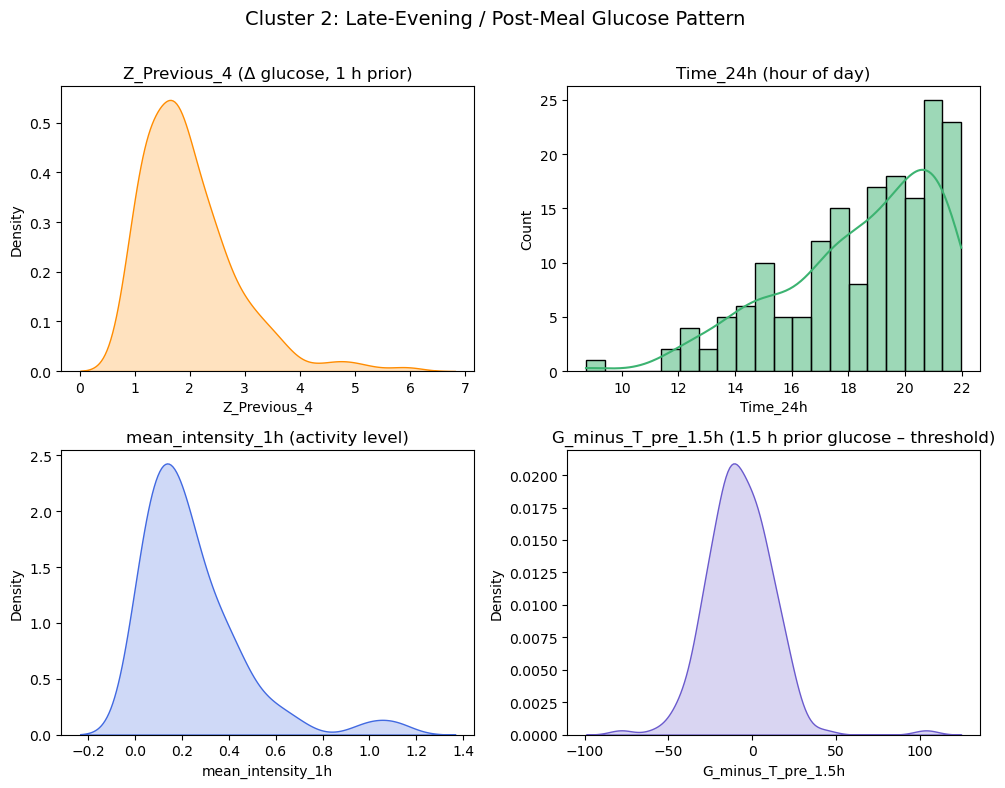

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster2 = merged_df.query("Cluster == 2")

plot_vars = ["Z_Previous_4", "Time_24h", "mean_intensity_1h", "G_minus_T_pre_1.5h"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# Z_Previous_4 (Δ glucose, 1 h prior)
sns.kdeplot(cluster2["Z_Previous_4"], fill=True, color="darkorange", ax=axes[0])
axes[0].set_title("Z_Previous_4 (Δ glucose, 1 h prior)")
axes[0].set_xlabel("Z_Previous_4")
axes[0].set_ylabel("Density")

# Time_24h (hour of day)
sns.histplot(cluster2["Time_24h"], bins=20, kde=True, color="mediumseagreen",
             edgecolor="black", ax=axes[1])
axes[1].set_title("Time_24h (hour of day)")
axes[1].set_xlabel("Time_24h")
axes[1].set_ylabel("Count")

# mean_intensity_1h (activity)
sns.kdeplot(cluster2["mean_intensity_1h"], fill=True, color="royalblue", ax=axes[2])
axes[2].set_title("mean_intensity_1h (activity level)")
axes[2].set_xlabel("mean_intensity_1h")
axes[2].set_ylabel("Density")

# G_minus_T_pre_1.5h (1.5 h prior glucose – threshold)
sns.kdeplot(cluster2["G_minus_T_pre_1.5h"], fill=True, color="slateblue", ax=axes[3])
axes[3].set_title("G_minus_T_pre_1.5h (1.5 h prior glucose – threshold)")
axes[3].set_xlabel("G_minus_T_pre_1.5h")
axes[3].set_ylabel("Density")

plt.suptitle("Cluster 2: Late-Evening / Post-Meal Glucose Pattern", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Cluster 3

In [27]:
import pandas as pd

cluster3 = merged_df.query("Cluster == 3")

key_vars_3 = [
    "mean_intensity_1h",
    "Time_24h",
    "hungry",
    "hungry_within",
    "TimeInBed"
]

summary_cluster3 = (
    cluster3[key_vars_3]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .T[["mean", "25%", "50%", "75%"]]
    .rename(columns={"mean": "Mean", "25%": "Q25", "50%": "Median", "75%": "Q75"})
)

print("=== Cluster 3 Summary (Raw Value) ===")
print(summary_cluster3.round(3))


=== Cluster 3 Summary (Raw Value) ===
                      Mean      Q25   Median      Q75
mean_intensity_1h    0.357    0.133    0.267    0.417
Time_24h            17.072   14.017   18.183   20.467
hungry_within        0.129   -0.224   -0.056    0.468
TimeInBed          413.557  333.000  431.000  494.000


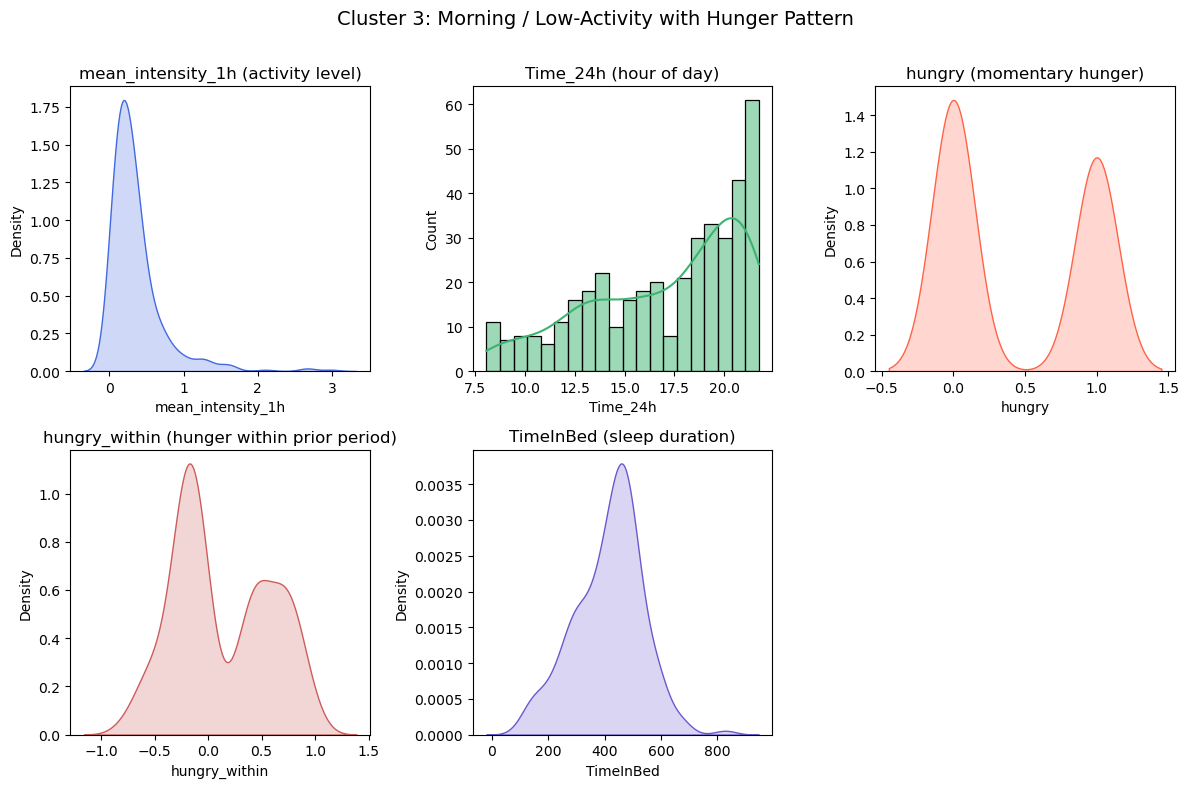

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
# Cluster 3
cluster3 = merged_df.query("Cluster == 3")

plot_vars_3 = ["mean_intensity_1h", "Time_24h", "hungry", "hungry_within", "TimeInBed"]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# mean_intensity_1h
sns.kdeplot(cluster3["mean_intensity_1h"], fill=True, color="royalblue", ax=axes[0])
axes[0].set_title("mean_intensity_1h (activity level)")
axes[0].set_xlabel("mean_intensity_1h")
axes[0].set_ylabel("Density")

# Time_24h
sns.histplot(cluster3["Time_24h"], bins=20, kde=True, color="mediumseagreen",
             edgecolor="black", ax=axes[1])
axes[1].set_title("Time_24h (hour of day)")
axes[1].set_xlabel("Time_24h")
axes[1].set_ylabel("Count")

# hungry
sns.kdeplot(cluster3["hungry"], fill=True, color="tomato", ax=axes[2])
axes[2].set_title("hungry (momentary hunger)")
axes[2].set_xlabel("hungry")
axes[2].set_ylabel("Density")

# hungry_within
sns.kdeplot(cluster3["hungry_within"], fill=True, color="indianred", ax=axes[3])
axes[3].set_title("hungry_within (hunger within prior period)")
axes[3].set_xlabel("hungry_within")
axes[3].set_ylabel("Density")

# TimeInBed
sns.kdeplot(cluster3["TimeInBed"], fill=True, color="slateblue", ax=axes[4])
axes[4].set_title("TimeInBed (sleep duration)")
axes[4].set_xlabel("TimeInBed")
axes[4].set_ylabel("Density")

# 마지막 빈 subplot 숨기기
fig.delaxes(axes[5])

plt.suptitle("Cluster 3: Morning / Low-Activity with Hunger Pattern", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Compare with TP vs. FP in Cluster 3

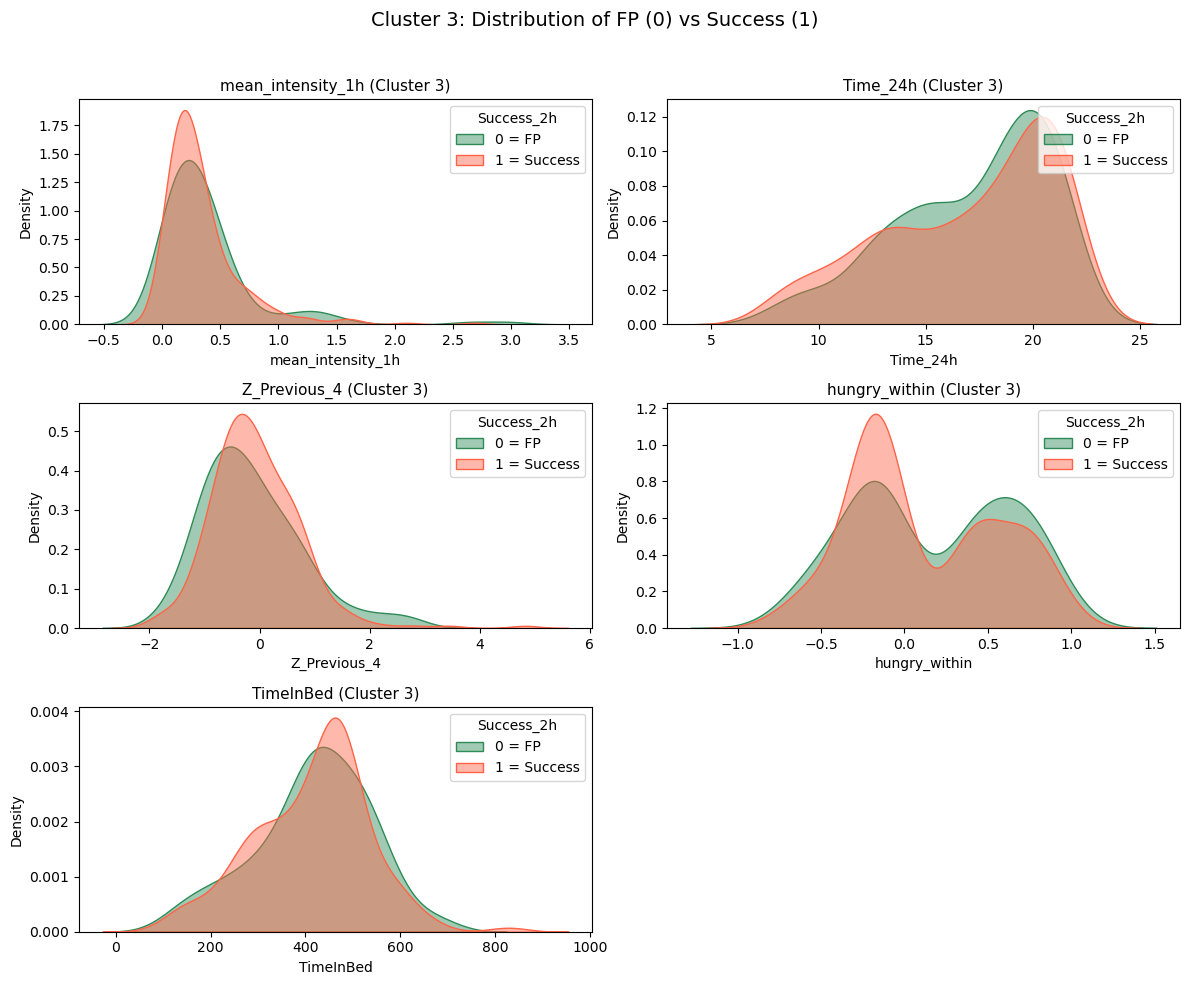

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------
# 1️⃣ Filter Cluster 3 only
# --------------------------------------------------
cluster3_df = merged_df.query("Cluster == 3")

# --------------------------------------------------
# 2️⃣ Define variables to compare
# --------------------------------------------------
vars_to_plot = ["mean_intensity_1h", "Time_24h", "Z_Previous_4", "hungry_within", "TimeInBed"]

# --------------------------------------------------
# 4️⃣ KDE plots comparing Success vs FP
# --------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

palette = {1: "seagreen", 0: "tomato"}

for i, var in enumerate(vars_to_plot):
    sns.kdeplot(
        data=cluster3_df,
        x=var,
        hue="Success_2h",
        fill=True,
        common_norm=False,
        palette=palette,
        alpha=0.45,
        ax=axes[i]
    )
    axes[i].set_title(f"{var} (Cluster 3)", fontsize=11)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Density")
    axes[i].legend(title="Success_2h", labels=["0 = FP", "1 = Success"])

# Hide any unused subplot
for j in range(len(vars_to_plot), len(axes)):
    axes[j].axis("off")

plt.suptitle("Cluster 3: Distribution of FP (0) vs Success (1)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Dummy messages

## Cluster 1 (Meal Time Cluster)
Features: Hungry, hungry-within (0.6–7), evening (18–21h), low glucose (q25 ≈ 65–75), sedentary.

Scenarios: Strong hunger in the evening with low glucose → high likelihood of initiating a meal.
Sedentary context may amplify postprandial glucose rise.

Message strategy: Hungry or Not -> Food portion message

## Cluster 2 (Late Night Snack Cluster)
Features: Not hungry, glucose rising, late evening (20–21h), sedentary/light activity.

Scenarios: Rising glucose without hunger → already eating or just finished eating.
Late evening slows postprandial clearance → higher GE risk within the next hour.

Alternative scenario: stress- or fatigue-driven late-night snacking.
Message strategy: Late night Yes or No, Hungry Yes or No -> 4 types of messages

## Cluster 3 (Late Dinner, Stable)
Features: Not hungry (hungry), Evening (18–22h), stable glucose (~88), sedentary/light activity.

Scenarios: Not hungry and glucose stable → good opportunity to maintain balance.
Low activity means sudden eating could still trigger GE.

Additional scenario: habitual late night meals → glucose spikes from otherwise stable state.
Message strategy: Late night Yes or No, Hungry Yes or No -> 4 types of messages


# Cluster 1: Meal time 
# Cluster 2: Late night snack
# Cluster 3: Late dinner

In [58]:
import numpy as np
import pandas as pd

# ===============================
# 1. Define message templates
# ===============================
message_templates = {
    1: "You are hungry with lower glucose → choose balanced foods and moderate portions.",

    # Cluster 2 (Late-night snack)
    "2_yes_yes": "Snack wisely — if you’re craving a late-night snack, choose a light, balanced option and avoid high-sugar foods.",
    "2_yes_no": "It’s late — if you’re not hungry, avoid mindless snacking. Try winding down with water or herbal tea instead.",
    "2_no_yes": "You’re feeling hungry — have a balanced, portion-controlled snack like yogurt, fruit, or nuts.",
    "2_no_no": "Stay mindful of your habits and maintain balance through your evening routine.",

    # Cluster 3 (Stable / Late dinner)
    "3_yes_yes": "It’s getting late — if you’re hungry, opt for a light dinner to support better glucose overnight.",
    "3_yes_no": "It’s late — try to finish your day without extra intake to help your body rest and recover.",
    "3_no_yes": "You’re doing well — if you’re hungry, choose a balanced meal to maintain stability.",
    "3_no_no": "You’re in a good state — stay consistent with your healthy evening routine."
}

# ===============================
# 2. Copy dataset
# ===============================
dummy_df = merged_df.copy()

# ===============================
# 3. Cluster 1 (Meal Time Message)
# ===============================
cond1 = (
    (dummy_df["Cluster"] == 1)
    & (dummy_df["hungry_within"] >= 0.4))


dummy_df.loc[cond1, "dummy_message"] = message_templates[1]

# ===============================
# 4. Cluster 2 (Late-night snack logic)
# ===============================
cond2 = (dummy_df["Cluster"] == 2)
late_night = dummy_df["Time_24h"] >= 19
hungry_flag = dummy_df["hungry_within"] >= 0.3

dummy_df.loc[cond2 & late_night & hungry_flag, "dummy_message"] = message_templates["2_yes_yes"]
dummy_df.loc[cond2 & late_night & ~hungry_flag, "dummy_message"] = message_templates["2_yes_no"]
dummy_df.loc[cond2 & ~late_night & hungry_flag, "dummy_message"] = message_templates["2_no_yes"]
dummy_df.loc[cond2 & ~late_night & ~hungry_flag, "dummy_message"] = message_templates["2_no_no"]

# ===============================
# 5. Cluster 3 (Stable / Late dinner logic)
# ===============================
cond3 = (dummy_df["Cluster"] == 3)

dummy_df.loc[cond3 & late_night & hungry_flag, "dummy_message"] = message_templates["3_yes_yes"]
dummy_df.loc[cond3 & late_night & ~hungry_flag, "dummy_message"] = message_templates["3_yes_no"]
dummy_df.loc[cond3 & ~late_night & hungry_flag, "dummy_message"] = message_templates["3_no_yes"]
dummy_df.loc[cond3 & ~late_night & ~hungry_flag, "dummy_message"] = message_templates["3_no_no"]

# ===============================
# 6. Filter only rows where message is sent
# ===============================
dummy_messages = dummy_df.dropna(subset=["dummy_message"])[
    ["StudyID", "Cluster", "Time_24h", "hungry_within", "dummy_message"]
]

print(f"Generated {len(dummy_messages)} dummy messages (out of {len(merged_df)})")
dummy_messages.head(10)


Generated 633 dummy messages (out of 634)


,StudyID,Cluster,Time_24h,hungry_within,dummy_message
0,1,2,18.700000,-0.189526,Stay mindful of your habits and maintain balan...
1,1,2,20.950000,-0.189526,"It’s late — if you’re not hungry, avoid mindle..."
2,1,1,15.950000,0.810474,You are hungry with lower glucose → choose bal...
3,1,2,18.950000,-0.189526,Stay mindful of your habits and maintain balan...
4,1,2,20.700000,-0.189526,"It’s late — if you’re not hungry, avoid mindle..."
5,1,2,19.950000,-0.189526,"It’s late — if you’re not hungry, avoid mindle..."
6,1,3,21.700000,-0.189526,It’s late — try to finish your day without ext...
7,1,3,20.700000,0.810474,"It’s getting late — if you’re hungry, opt for ..."
8,2,3,18.816667,-0.018519,You’re in a good state — stay consistent with ...
9,2,3,21.316667,-0.018519,It’s late — try to finish your day without ext...


In [60]:
# Save the modified DataFrame to CSV
dummy_messages.to_csv("dummy_messages.csv", index=False)
